<a href="https://colab.research.google.com/github/NyanSwanAung/TensorFlow-Beginner/blob/main/mini_project2_image_classification_with_CIFAR10(answer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<figure>
<center>
<img src='https://raw.githubusercontent.com/alexsnowschool/TensorFlow-Beginner/main/project_img.png' width = '800px'/>
</center>        
</figure>

# Image Classification with CIFAR10 Dataset


The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.
There are 50000 training images and 10000 test images.

<figure>
<center>
<img src='https://raw.githubusercontent.com/NyanSwanAung/TensorFlow-Beginner/main/coding-exercise/week4/CIFAR10%20Dataset.png' width = '800px'/>
</center>        
</figure>

# Step 1: Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.getcwd()

'/content'

In [3]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)

print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU? True


# Step 2: Preprocess Data

Total = 50000 images

X_Train = (15000, 32, 32, 3), Y_train = (15000, 3)

X_Test = (3000, 32, 32, 3), Y_test = (3000, 3)


### One-hot encoding 

After this encoding, every label will be converted to a list with 3 elements and the element at index to the corresponding class will be set to 1, rest will be set to 0:

| original label | one-hot encoded label |
|------|------|
| Aeroplane : 0 | [1, 0, 0] |
| Car : 1 | [0, 1, 0] |
| Bird : 2 | [0, 0, 1] |

In [4]:
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.) # aeroplance
    indices_1, _ = np.where(y == 1.) # car
    indices_2, _ = np.where(y == 2.) # bird

    print('Len of X:', len(x))
    print('Len of label:', np.unique(y))
    print('Indices 0:', indices_0, 'Indices 1:', indices_1, 'Indices 2:', indices_2)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    print('Concantenated Indices:', indices)
    
    x = x[indices]
    y = y[indices]
    print('X:', x, 'Y:', y)

    count = x.shape[0] # number total images of label 0,1,2 --> 15000
    print('Shape of X:', x.shape)
    print('Range of count:', range(count))

    indices = np.random.choice(range(count), count, replace=False) # ([0, 15000], 15000, )
    
    x = x[indices]
    y = y[indices]

    print('Random X:', x)
    print('Random Y:', y)
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Step 3: Visualize Examples

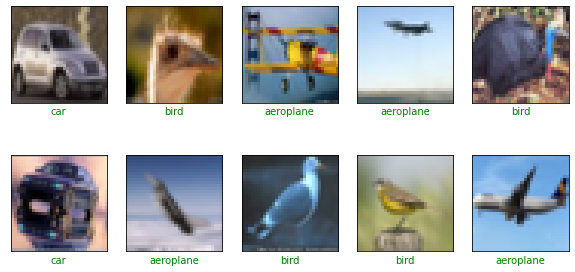

In [6]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, 1 + i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color = col)

    plt.show()

show_random_examples(x_train, y_train, y_train)
       

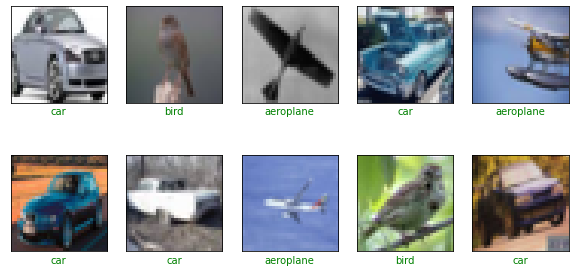

In [7]:
show_random_examples(x_test, y_test, y_test)

# Step 4: Create Model

In [8]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from tensorflow.keras.models import Sequential

model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(32, 32, 3)),
        MaxPooling2D(pool_size=2),
        

        Conv2D(64, (3,3), activation ='relu', padding = 'same'),
        MaxPooling2D(pool_size=2),
        

        Conv2D(128, (3,3), activation ='relu', padding = 'same'),
        MaxPooling2D(pool_size=2),
        

        Flatten(),
        Dense(128, activation='relu'),
        Dense(3, activation='softmax')
])

model.compile(
        loss='categorical_crossentropy',
        optimizer='adam', metrics=['accuracy']
    )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

# Step 5: Train the Model

In [9]:
history = model.fit(
    x_train/255., y_train,
    validation_data=(x_test/255., y_test),
    epochs=20, batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_{val_accuracy:.3f}.h5',
             save_best_only=True,
             save_weights_only=False,
             monitor='val_accuracy'
        )
    ]
)

Epoch 1/20
118/118 [==============================] - 1s 10ms/step - loss: 0.6654 - accuracy: 0.7194 - val_loss: 0.5273 - val_accuracy: 0.7857
Epoch 2/20
118/118 [==============================] - 1s 7ms/step - loss: 0.4043 - accuracy: 0.8377 - val_loss: 0.3442 - val_accuracy: 0.8600
Epoch 3/20
118/118 [==============================] - 1s 7ms/step - loss: 0.3310 - accuracy: 0.8706 - val_loss: 0.3313 - val_accuracy: 0.8713
Epoch 4/20
118/118 [==============================] - 1s 7ms/step - loss: 0.2972 - accuracy: 0.8863 - val_loss: 0.3184 - val_accuracy: 0.8733
Epoch 5/20
118/118 [==============================] - 1s 7ms/step - loss: 0.2657 - accuracy: 0.8961 - val_loss: 0.3053 - val_accuracy: 0.8830
Epoch 6/20
118/118 [==============================] - 1s 7ms/step - loss: 0.2246 - accuracy: 0.9147 - val_loss: 0.2802 - val_accuracy: 0.8913
Epoch 7/20
118/118 [==============================] - 1s 7ms/step - loss: 0.2000 - accuracy: 0.9251 - val_loss: 0.2592 - val_accuracy: 0.9070
Epoch

# Step 6: Final Predictions

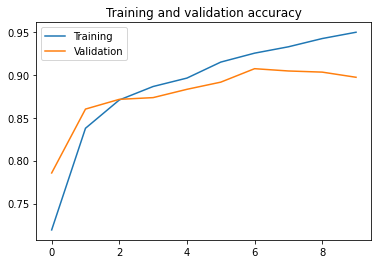

In [10]:
accs = history.history['accuracy']
val_accs = history.history['val_accuracy']
epochs = range(len(accs))

plt.plot(epochs, accs, label='Training')
plt.plot(epochs, val_accs, label='Validation')
plt.legend()
plt.title('Training and validation accuracy')
plt.show()

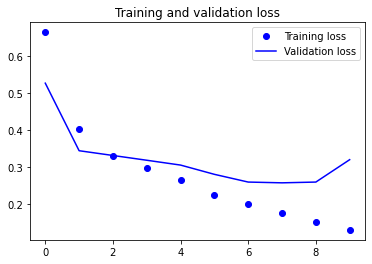

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [13]:
model = tf.keras.models.load_model('models/model_0.907.h5')

In [ ]:
pred = model.predict(x_test/255.)

In [ ]:
show_random_examples(x_test, y_test, pred)

In [15]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for file_name in uploaded.keys():
 
  # predicting images
  path = '/content/' + file_name
  img = image.load_img(path, target_size=(32, 32))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print()
  print('Classes[0]:', classes[0])

# aeroplane, # car, # bird

  if classes[0][0].astype('int') == 1:
    print(file_name, ' is an', 'aeroplane')
  elif classes[0][1].astype('int') == 1:
    print(file_name, ' is a', 'car')
  elif classes[0][2].astype('int') == 1:
    print(file_name, ' is a', 'bird')

 

Saving a1.jpeg to a1 (1).jpeg
Saving a2.jpg to a2 (1).jpg
Saving b1.jpg to b1 (1).jpg
Saving b2.jpg to b2 (1).jpg
Saving c1.jpeg to c1 (1).jpeg
Saving c2.jpg to c2 (1).jpg

Classes[0]: [1. 0. 0.]
a1.jpeg  is an aeroplane

Classes[0]: [1. 0. 0.]
a2.jpg  is an aeroplane

Classes[0]: [1. 0. 0.]
b1.jpg  is an aeroplane

Classes[0]: [0. 0. 1.]
b2.jpg  is a bird

Classes[0]: [0. 1. 0.]
c1.jpeg  is a car

Classes[0]: [0. 1. 0.]
c2.jpg  is a car
